In [7]:
from mmdet.apis import init_detector, inference_detector, async_inference_detector, show_result_pyplot
from mmdet.utils.contextmanagers import concurrent
import numpy as np
import matplotlib.pyplot as plt 
import pycocotools.mask as maskUtils
import mmcv
import cv2
import os 
import glob
import time
import sys

from matplotlib import patches,  lines, colors
from skimage.morphology import medial_axis, skeletonize
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, label, regionprops_table
import json
import slidingwindow as sw

# import shm_tools here
sys.path.append('..')
from shm_tools.shm_utils import imread, imwrite, inference_detector_sliding_window, connect_cracks, remove_cracks

In [9]:
# write a code the mmdetection result in the form of mattaport mask rcnn 

config = '/home/soojin/mmdetection/project_work_dirs/sukkyung/configs/cascade_mask_rcnn_x101_64x4d_fpn_1x_for_crack.py'
checkpoint = '/home/soojin/mmdetection/project_work_dirs/sukkyung/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_for_crack/epoch_30.pth'
# download the checkpoint from model zoo and put it in `checkpoints/`

device = 'cuda:0'
model = init_detector(config, checkpoint, device=device)



In [ ]:
color_mask = np.array([[255, 0, 0],
                       [0, 255, 0],
                       [0, 255, 255],
                       [255, 0, 255],
                      ], dtype=np.uint8)

img_folder = '/home/soojin/mmdetection/project_work_dirs/sukkyung/test'
img_path_list = glob.glob(os.path.join(img_folder, '*.jpg')) + glob.glob(os.path.join(img_folder, '*.JPG'))

for img_path in img_path_list : 
    img_result_1, mask_output = inference_detector_sliding_window(model, img_path, color_mask[0], score_thr = 0.1, window_size = 1024, overlap_ratio = 0.3)
    if np.sum(mask_output) > 0:
        mask_output = connect_cracks(mask_output)
        mask_output = connect_cracks(mask_output)
        mask_output = remove_cracks(mask_output) 

        filename_result = os.path.basename(img_path)[:-4] + '_result.jpeg'
        filename_result = os.path.join(img_folder, filename_result)
        imwrite(filename_result, img_result_1)

        filename_result_after_connect = os.path.basename(img_path)[:-4] + '_result_connected.jpeg'
        filename_result_after_connect = os.path.join(img_folder, filename_result_after_connect)

        img_result_after_connect = imread(img_path)
        mask_output_bool = mask_output.astype(np.bool)
        img_result_after_connect[mask_output_bool, :] = img_result_after_connect[mask_output_bool, :] * 0.3 + color_mask[0] * 0.6
        imwrite(filename_result_after_connect, img_result_after_connect)
    elif np.sum(mask_output) == 0:
        print(img_path + ' has no crack detection result')

inference by sliding window on img0_0.jpg: 100%|##########| 182/182 [01:08<00:00,  2.65it/s]
/home/soojin/mmdetection/shm_tools/shm_utils.py:201: RuntimeWarning: invalid value encountered in arccos
  angle_1 = np.arccos(dot_product)
inference by sliding window on img0_9500.jpg: 100%|##########| 182/182 [01:09<00:00,  2.63it/s]


In [7]:
color_mask = np.array([[255, 0, 0],
                       [0, 255, 0],
                       [0, 255, 255],
                       [255, 0, 255],
                      ], dtype=np.uint8)

input_img = '/home/soojin/다운로드/20200227-1257-Stitching/126(892)_118110.24cm.jpg'



mask_output_bool = mask_output.astype(np.bool)

# Add colors to detection result on img
img_result = imread(input_img)
img_result[mask_output_bool, :] = img_result[mask_output_bool,:] * 0.3 + color_mask[0] * 0.6

imwrite('/home/soojin/다운로드/20200227-1257-Stitching/126(892)_118110.24cm_result.jpg', img_result)

filename_result =  img_path[:-4] + '_result.jpeg'
imwrite(filename_result, img_result)

img_result_after_thresholding = img.copy()
filename_result_after_connect =  img_path[:-4] + '_result_connected.jpeg'

img_result_after_connect = img.copy()
mask_output_bool = mask_output.astype(np.bool)
img_result_after_connect[mask_output_bool, :] = img_result_after_connect[mask_output_bool, :] * 0.3 + color_mask * 0.6
imwrite(filename_result_after_connect, img_result_after_connect)



inference by sliding window on 126(892)_118110.24cm.jpg: 100%|##########| 165/165 [00:25<00:00,  6.48it/s]
/home/soojin/mmdetection/shm_tools/shm_utils.py:208: RuntimeWarning: invalid value encountered in true_divide
  unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
/home/soojin/mmdetection/shm_tools/shm_utils.py:198: RuntimeWarning: invalid value encountered in true_divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
/home/soojin/mmdetection/shm_tools/shm_utils.py:207: RuntimeWarning: invalid value encountered in true_divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)


True

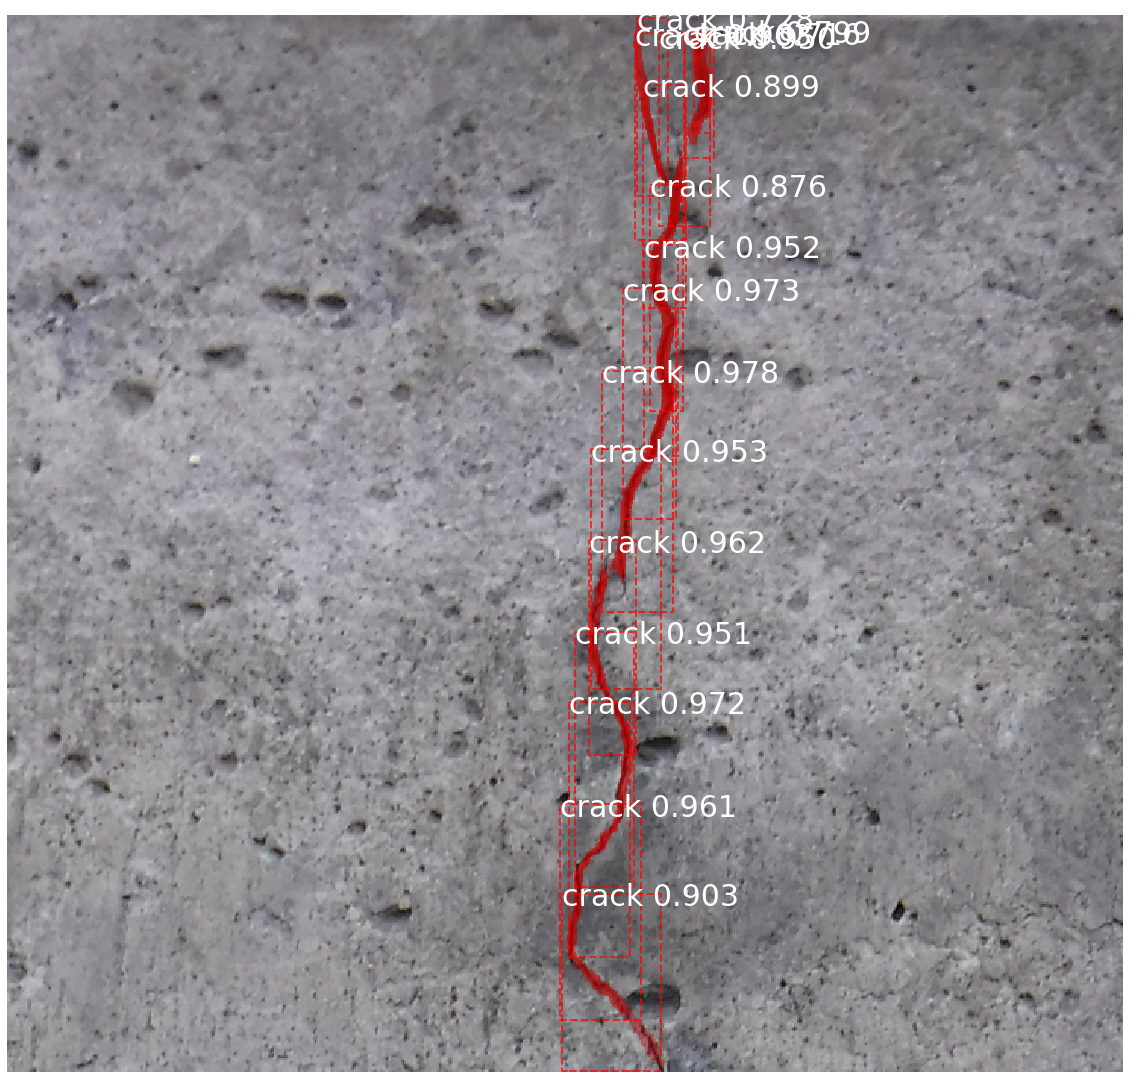

In [45]:
img = '/home/soojin/mmdetection/data/concrete_damage_autocon/test2018/con_damage_bh_052_.jpg'
results = inference_detector(model, img)

img_resulimg_resultt = imread(img)
bbox_result, segm_result = results

score_thr = 0.5

color_mask = np.array([[255, 0, 0],
                       [0, 255, 0],
                       [0, 255, 255],
                       [255, 0, 255],
                      ], dtype=np.uint8)

color_mask_ = ['r', 'g', 'c', 'm']
classes = ['crack', 'effl', 'rebar', 'spll']
segms = mmcv.concat_list(segm_result)
mask_semantic_seg = np.zeros((segms[0]['size'][0], segms[0]['size'][1], 5), dtype = np.float32)

_, ax = plt.subplots(1, figsize = (20,20))
# 
for class_num, bbox_with_class in enumerate(bbox_result) : 
        for box_num, bbox in enumerate(bbox_with_class) :
            if bbox[-1] > 0.5 :
                mask = np.asarray(maskUtils.decode(segm_result[class_num][box_num]), dtype= np.bool) 
                img_result[mask] = img_result[mask] * 0.6 + color_mask[class_num] * 0.3
                mask_semantic_seg[:,:, class_num+1] += mask  
                color = tuple(color_mask[class_num])
#                 color = colors.to_rgba(color)
                x1, y1, x2, y2, _ = bbox
                p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color_mask_[class_num], facecolor='none')
                ax.add_patch(p)
                caption = "{} {:.3f}".format(classes[class_num], bbox[-1])
                ax.text(x1, y1 + 8, caption,
                        color='w', size=30, backgroundcolor="none")
                
mask_semantic_seg[mask_semantic_seg > 1] = 1
seg_2d = np.zeros((img_result.shape[0], img_result.shape[1], 3), dtype = np.uint8)
seg_2d[mask_semantic_seg[:, :, 2] == 1] = [0, 255, 0] # efflorescence _non_overlap
seg_2d[mask_semantic_seg[:, :, 4] == 1] = [255, 0, 255] # spalling 
seg_2d[mask_semantic_seg[:, :, 3] == 1] = [0, 255, 255] # rebar exposure 
seg_2d[mask_semantic_seg[:, :, 1] == 1] = [255, 0, 0] # crack 
                
ax.axis('off')
ax.imshow(img_result)


In [161]:
img = '/home/soojin/다운로드/concrete_damage_detection/tunnel_200121_0007.JPG'
results = inference_detector(model, img)
# show_result_pyplot(img, results, model.CLASSES,  score_thr=0.7, fig_size=(20, 20))
img_result = imread(img) 
bbox_result, segm_result = results
mask_output = np.zeros((img_result.shape[0], img_result.shape[1]), dtype=np.bool)
mask_sum = np.zeros((img_result.shape[0], img_result.shape[1]), dtype=np.bool)            
# bboxes = np.vstack(bbox_result[3]) # bboxes 
bboxes = bbox_result[1]
# draw segmentation masks

# if segm_result is not None:
score_thr = 0.7
# segms = mmcv.concat_list(segm_result)
segms = segm_result[1]
inds = np.where(bboxes[:, -1] > score_thr)[0]
for i in inds:
    color_mask = np.array([[0, 255, 0]], dtype=np.uint8)
    mask = maskUtils.decode(segms[i]).astype(np.bool)
    mask_sum = mask_sum + mask 
    img_result[mask] = img_result[mask] * 0.3 + color_mask * 0.6

mask_output = mask_sum
mask_output = mask_output.astype(np.uint8)

mask_output[mask_output > 1] = 1

In [162]:
filename_result = '/home/soojin/다운로드/concrete_damage_detection/tunnel_200121_0007_detection_result.jpeg'
imwrite(filename_result, img_result)

True

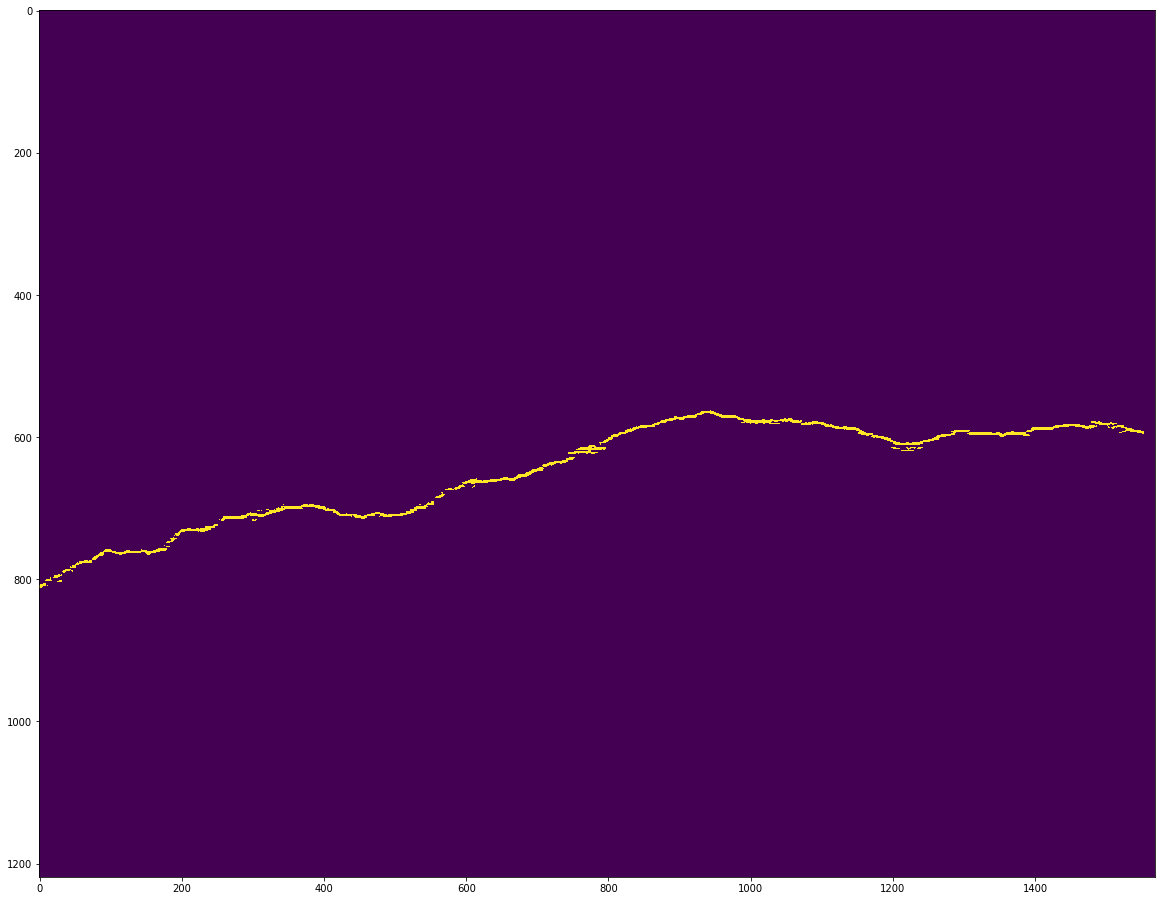

In [78]:
img_ = imread(img) 
img_grey = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)

th2 = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)



th2 = 255-th2 
th2[mask_output == 0] = 0
labels, num = label(th2, connectivity=2, return_num=True)
R = regionprops_table(labels, properties=('label', 'bbox', 'area', 'coords'))
for img_num, area in enumerate(R['area']):
    if area < 10 :
        c = R['coords'][img_num]
        for c_ in c: 
            th2[c_[0], c_[1]] = 0
plt.figure(figsize=(20,20))
plt.imshow(th2)

In [79]:
filename_result = '/home/soojin/다운로드/concrete_damage_detection/tunnel_200213_0210_imbinarize.jpeg'
imwrite(filename_result, th2)

True

In [9]:
config_file = '/home/soojin/mmdetection/project_work_dirs/express_cor/configs/cascade_mask_rcnn_x101_64x4d_fpn_carafe_1x_road_crack_200318.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
checkpoint_file = '/home/soojin/mmdetection/project_work_dirs/express_cor/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_carafe_1x_road_crack_200318/epoch_30.pth'

device = 'cuda:0'
model = init_detector(config_file, checkpoint_file, device=device)

img_folder = '/home/soojin/mmdetection_carafe/demo/exdemo_200220/아스팔트/'
img_path_list = glob.glob(os.path.join(img_folder, '*.jpg')) + glob.glob(os.path.join(img_folder, '*.JPG'))

for img_path in img_path_list : 

    img = imread(img_path)
    img_result = img.copy()
    score_thr = 0.1
    # Generate the set of windows, with a 256-pixel max window size and 50% overlap

    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 256+512, 0.5)
    mask_output = np.zeros((img.shape[0], img.shape[1]), dtype=np.bool)

    for window in windows: # Can a multithreading be used here?? 

        img_subset = img[window.indices()]
        results = inference_detector(model, img_subset)
        bbox_result, segm_result = results
        mask_sum = np.zeros((img_subset.shape[0], img_subset.shape[1]), dtype=np.bool)            
        bboxes = np.vstack(bbox_result) # bboxes 
        # draw segmentation masks

        if segm_result is not None:
            segms = mmcv.concat_list(segm_result)
            inds = np.where(bboxes[:, -1] > score_thr)[0]
            for i in inds:
                color_mask = np.array([[255, 0, 0]], dtype=np.uint8)
                mask = maskUtils.decode(segms[i]).astype(np.bool)
                mask_sum = mask_sum + mask 
                img_result[window.indices()][mask] = img_result[window.indices()][mask] * 0.3 + color_mask * 0.6

        mask_output[window.indices()] = mask_sum
        
    mask_output = mask_output.astype(np.uint8)
    
    mask_output[mask_output > 1] = 1
    mask_output = connect_cracks(mask_output)
    mask_output = connect_cracks(mask_output)
    
    labels, num = label(mask_output, connectivity=2, return_num=True)
    crack_region_table = regionprops_table(labels, properties=('label', 'bbox', 'coords'))

    width = crack_region_table['bbox-3'] - crack_region_table['bbox-1']
    height = crack_region_table['bbox-2'] - crack_region_table['bbox-0']
    crack_region_table['diagonal_length'] = np.sqrt(height**2 + width**2)

    for crack_num in range(len(crack_region_table['label'])): 
        if crack_region_table['diagonal_length'][crack_num] < 300 : 
            for c in crack_region_table['coords'][crack_num]:
                mask_output[c[0], c[1]] = 0
                
    filename_result =  img_path[:-4] + '_result.jpeg'
    imwrite(filename_result, img_result)
    
    img_result_after_thresholding = img.copy()
    filename_result_after_connect =  img_path[:-4] + '_result_connected.jpeg'

    img_result_after_connect = img.copy()
    mask_output_bool = mask_output.astype(np.bool)
    img_result_after_connect[mask_output_bool, :] = img_result_after_connect[mask_output_bool, :] * 0.3 + color_mask * 0.6
    imwrite(filename_result_after_connect, img_result_after_connect)



In [14]:
start = time.time()

filename_mask =  img_path[:-4] + '_mask.png'

# kernel = np.ones((50,50),np.uint8)
# mask_output =  cv2.dilate(mask_output.astype(np.uint8),kernel,iterations = 1)


imwrite(filename_mask, mask_output*255)


end = time.time()
print(end - start)
#         filename_mask = filename[:-4] + '_mask.png'
#         imwrite(os.path.join(dirpath, filename_result), result_image)


1.5944864749908447


In [294]:
labels, num = label(mask_output, connectivity=2, return_num=True)
crack_region_table = regionprops_table(labels, properties=('label', 'bbox', 'coords', 'orientation'))

n = len(crack_region_table['label']) 

width = crack_region_table['bbox-3'] -crack_region_table['bbox-1']
height = crack_region_table['bbox-2'] -crack_region_table['bbox-0']

crack_region_table['is_horizontal'] = width > height

e2_list = []
e1_list = []

for crack_num, crack_region in enumerate(crack_region_table['label']):
    
    min_row = crack_region_table['bbox-0'][crack_num]
    min_col = crack_region_table['bbox-1'][crack_num]
    max_row = crack_region_table['bbox-2'][crack_num]-1
    max_col = crack_region_table['bbox-3'][crack_num]-1
    
    if crack_region_table['is_horizontal'][crack_num] : 
        # max col / min col 
        col = crack_region_table['coords'][crack_num][:, 1]
        
        e2 = crack_region_table['coords'][crack_num][np.argwhere(col == max_col), :][-1][0]
        e1 = crack_region_table['coords'][crack_num][np.argwhere(col == min_col), :][0][0]
        
        e2_list.append(e2)
        e1_list.append(e1)
        
    else: 
        # max row / min row
        row = crack_region_table['coords'][crack_num][:, 0]
        
        e2 = crack_region_table['coords'][crack_num][np.argwhere(row == max_row), :][-1][0]
        e1 = crack_region_table['coords'][crack_num][np.argwhere(row == min_row), :][0][0]
        
        e2_list.append(e2)
        e1_list.append(e1)
        
        
crack_region_table['e2'] = e2_list
crack_region_table['e1'] = e1_list

        
        
        

In [361]:
k = 0

connect_line_img = np.zeros_like(img, dtype = np.uint8)
n = len(crack_region_table['label']) 
d = []
epsilon = 100
color = (255, 255, 255)

for i in range(n):
    k_list = []
    for k in range(n) : 
        if not k == i :
            distance = []
            e_list = []
            
            for e1 in ['e1', 'e2'] : 
                for e2 in ['e1', 'e2'] : 
        
                    d = np.subtract(crack_region_table[e1][k], crack_region_table[e2][i])   
                    distance.append(np.sqrt(d[0]**2 + d[1]**2))
                    e_list.append([e1, e2])
            if not k_list : 
                k_list.append([distance, e_list, k])
                
            elif np.min(k_list[0][0]) > np.min(distance) : 
                k_list = []
                k_list.append([distance, e_list, k])
            
    if np.min(k_list[0][0]) < epsilon : 

        dist_idx = np.argmin(k_list[0][0])

        e1, e2 = k_list[0][1][dist_idx]
        
        k_ = k_list[0][2]

        start_point = crack_region_table[e1][k_][::-1]
        end_point = crack_region_table[e2][i][::-1]

        d_theta = abs(crack_region_table['orientation'][k] - crack_region_table['orientation'][i])
#             print('check1')

#             if  d_theta <= np.pi/2 : 
#                 print('check2')

        connect_line_img = cv2.line(connect_line_img , tuple(start_point), tuple(end_point), color, 4) 

    


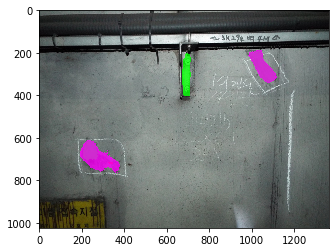

In [159]:
image = imread(img)
result_image = model_detect_by_grid(image)

imwrite(os.path.join(dirpath, filename_result), result_image)

In [165]:
config_file = '/home/soojin/mmdetection_carafe/configs/multiple_damage_detection/mask_rcnn_r101_fpn_1x_mask_56.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
checkpoint_file = '/home/soojin/mmdetection_carafe/work_dirs/concrete_damage_autocon/mask_rcnn_r101_fpn_1x_mask_56/epoch_30.pth'

In [97]:
# build the model from a config file and a checkpoint file
model_0 = init_detector(config_file, checkpoint_file, device='cuda:0')
model_1 = init_detector(config_file, checkpoint_file, device='cuda:1')
model_2 = init_detector(config_file, checkpoint_file, device='cuda:2')


MaskRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [90]:
model.CLASSES

('crack', 'effl', 'rebar', 'spll')

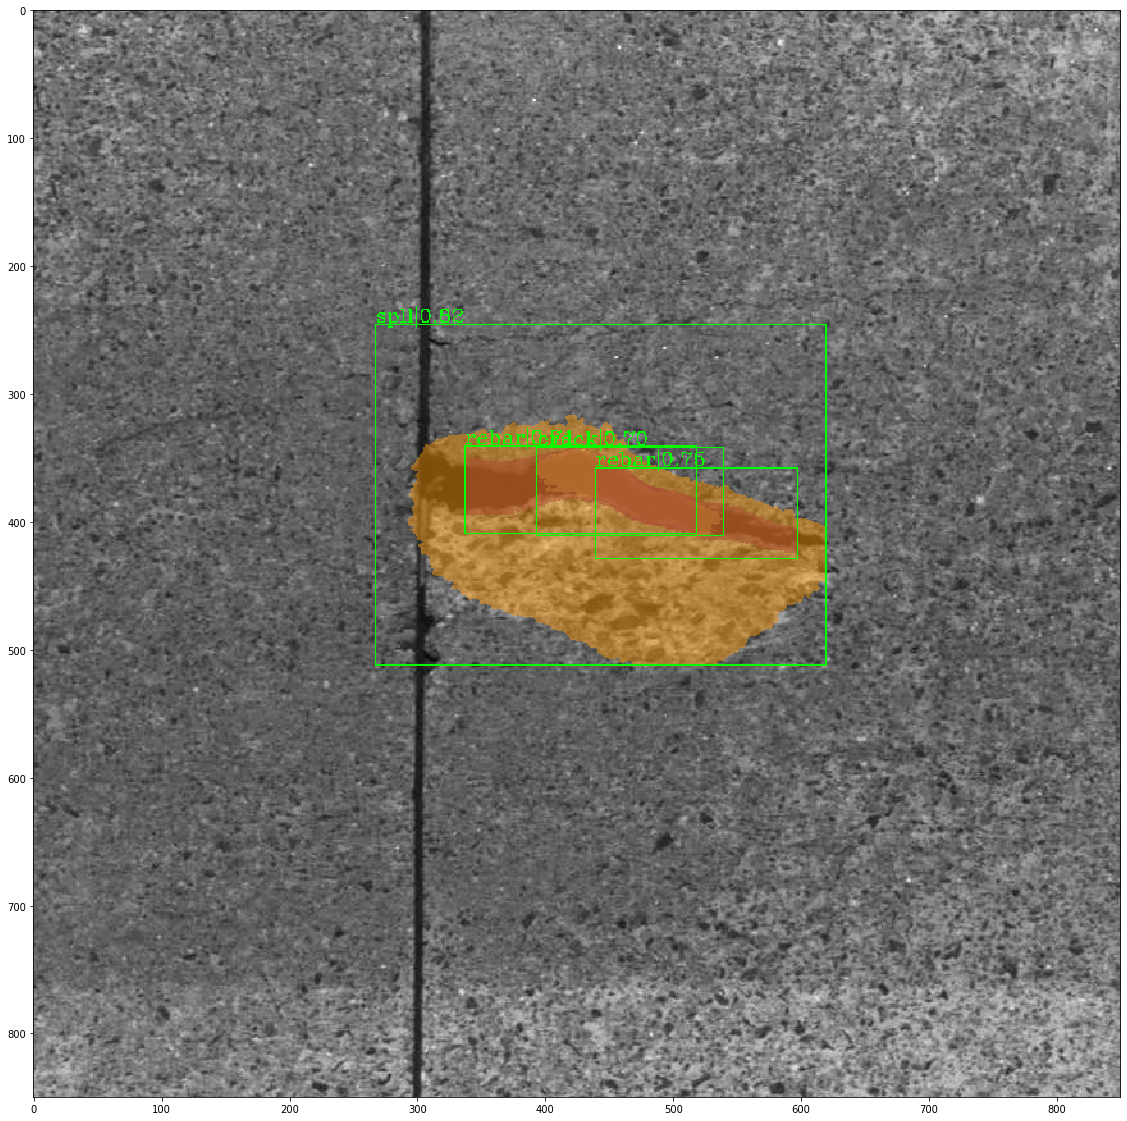

In [89]:
# test a single image
img = '/home/soojin/다운로드/concrete_damage_detection/200225_0005_53_1.jpg'
result = inference_detector(model, img)
# show the results
show_result_pyplot(img, result, model.CLASSES,  score_thr=0.7, fig_size=(20, 20))

In [179]:
for dirpath, dirnames, filenames in os.walk("/home/soojin/mmdetection_carafe/data/concrete_damage_autocon/test2018/mini/"):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        print(os.path.join(dirpath, filename))
        # test a large image 

        img = imread(os.path.join(dirpath, filename))
        result_image = model_detect_by_grid(img, score_thr=0.3)
        filename_result =  filename[:-4] + '_result.png'
#         filename_mask = filename[:-4] + '_mask.png'
        imwrite(os.path.join(dirpath, filename_result), result_image)

/home/soojin/mmdetection_carafe/data/concrete_damage_autocon/test2018/mini/crack_train_142.jpg
/home/soojin/mmdetection_carafe/data/concrete_damage_autocon/test2018/mini/200109_2_8_19_.jpg


In [8]:
crack_length_sum = 0
length_per_pixel = 0.35

for dirpath, dirnames, filenames in os.walk("/home/soojin/바탕화면/P34/└№╕щ║╬/originals"):
    for filename in [f for f in filenames if f.endswith(".JPG")]:
        print(os.path.join(dirpath, filename))
        # test a large image 

        img = imread(os.path.join(dirpath, filename))
        result_image, mask_output = model_detect_by_grid(img)
        filename_result =  filename[:-4] + '_result.jpg'
#         filename_mask = filename[:-4] + '_mask.png'
        imwrite(os.path.join(dirpath, filename_result), result_image)
#         imwrite(os.path.join(dirpath, filename_mask), (mask_output*255).astype(np.uint8))
        img = imread(os.path.join(dirpath, filename))

        # obtain only crack area 

        crack_area = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
        crack_area[(result_image[:,:,0] > 220) & (result_image[:,:,1] < 50) & (result_image[:,:,2] < 50)] = 1
        #img_med = skimage.color.rgb2gray(image_b) # convert ingto gray image 

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_med = cv2.medianBlur(img_gray.astype(np.uint8), 21) # median blur 

        img_sub = img_med.astype(np.float) - img_gray.astype(np.float) 
        img_sub[img_sub > 0] = 0
        thresh = threshold_otsu(img_sub)
        img_sub = img_sub < thresh
        img_sub[crack_area == 0] = 0

        skel_mask, distance = medial_axis(crack_area, return_distance=True)

        img_sub = (img_sub * 255).astype(np.uint8) + (skel_mask * 255).astype(np.uint8)
        img_sub[img_sub != 0] = 255

        skel, distance = medial_axis(img_sub, return_distance=True)
        dist_on_skel = distance * skel
        labels, num = label(crack_area, connectivity=2, return_num=True)

        label_save = np.zeros_like(img_sub, dtype=np.uint8)

        crack_data_json = {}
        crack_data_json['crack'] = []

        i = 0
        for R in regionprops(labels):

            if R.area > 50 and R.eccentricity > 0.9:
                i = i + 1
                crack_width = []
                length = 0 

                for c in R.coords:
                    label_save[c[0], c[1]] = i
                    if skel_mask[c[0], c[1]] : length += 1 

        #             length += 1 
                    crack_width.append(dist_on_skel[c[0], c[1]])

                crack_width = np.array(crack_width)
                crack_width = crack_width[np.nonzero(crack_width)].mean()
                crack_data_json['crack'].append({
                    'number': str(i),
                    # 'width': str(int(np.sum(dist_temp) / R_skel[0].area * 100) / 100),
                    'width': str(int(crack_width*100)*length_per_pixel/100) + 'mm',
                    'length': str(int(length*length_per_pixel)) + 'mm'
                })
                
                crack_length_sum = crack_length_sum + int(length*length_per_pixel)
                
        filename_label =  filename[:-4] + '_label.png'
        imwrite(os.path.join(dirpath, filename_label), label_save)     
        
        filename_text =  filename[:-4] + '_info.txt'
        with open(os.path.join(dirpath, filename_text), 'w') as outfile:
            json.dump(crack_data_json, outfile)

crack_length_sum_json = {}
crack_length_sum_json['summary'] = []
crack_length_sum_json['summary'].append({
    'length': str(crack_length_sum/10) + 'cm', 
    'area'  : str(crack_length_sum/10*25) + 'cm^2'
})

crack_length_text =  'crack_length_summary.txt'
with open(os.path.join(dirpath, crack_length_text), 'w') as outfile:
    json.dump(crack_length_sum_json, outfile)

            

/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0694.JPG
/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0726.JPG
/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0757.JPG
/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0689.JPG
/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0679.JPG
/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0729.JPG
/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0698.JPG
/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0773.JPG
/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0684.JPG
/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0667.JPG
/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0768.JPG
/home/soojin/바탕화면/P34/└№╕щ║╬/originals/DJI_0744.JPG


In [33]:
crack_length_sum = 0
length_per_pixel = 0.3

for dirpath, dirnames, filenames in os.walk("/home/soojin/mmdetection_carafe/data/concrete_damage_autocon/test2018/mini/"):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        print(os.path.join(dirpath, filename))
        # test a large image 

        img = imread(os.path.join(dirpath, filename))
        result_image, mask_output = model_detect_by_grid(img)
        filename_result =  filename[:-4] + '_result.JPG'
#         filename_mask = filename[:-4] + '_crack.png'
        imwrite(os.path.join(dirpath, filename_result), result_image)
#         imwrite(os.path.join(dirpath, filename_mask), (mask_output*255).astype(np.uint8))
#         img = imread(os.path.join(dirpath, filename))

        # obtain only crack area 

#         crack_area = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
#         crack_area[(result_image[:,:,0] > 220) & (result_image[:,:,1] < 50) & (result_image[:,:,2] < 50)] = 1
#         #img_med = skimage.color.rgb2gray(image_b) # convert into gray image 

#         img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img_med = cv2.medianBlur(img_gray.astype(np.uint8), 21) # median blur 

#         img_sub = img_med.astype(np.float) - img_gray.astype(np.float) 
#         img_sub[img_sub > 0] = 0
#         thresh = threshold_otsu(img_sub)
#         img_sub = img_sub < thresh
#         img_sub[crack_area == 0] = 0

#         skel_mask, distance = medial_axis(crack_area, return_distance=True)

#         img_sub = (img_sub * 255).astype(np.uint8) + (skel_mask * 255).astype(np.uint8)
#         img_sub[img_sub != 0] = 255

#         skel, distance = medial_axis(img_sub, return_distance=True)
#         dist_on_skel = distance * skel
#         labels, num = label(crack_area, connectivity=2, return_num=True)

#         label_save = np.zeros_like(img_sub, dtype=np.uint8)

#         crack_data_json = {}
#         crack_data_json['crack'] = []

#         i = 0
#         for R in regionprops(labels):

#             if R.area > 50 and R.eccentricity > 0.9:
#                 i = i + 1
#                 crack_width = []
#                 length = 0 

#                 for c in R.coords:
#                     label_save[c[0], c[1]] = i
#                     if skel_mask[c[0], c[1]] : length += 1 

#         #             length += 1 
#                     crack_width.append(dist_on_skel[c[0], c[1]])

#                 crack_width = np.array(crack_width)
#                 crack_width = crack_width[np.nonzero(crack_width)].mean()
#                 crack_data_json['crack'].append({
#                     'number': str(i),
#                     # 'width': str(int(np.sum(dist_temp) / R_skel[0].area * 100) / 100),
#                     'width': str(int(crack_width*100)*length_per_pixel/100) + 'mm',
#                     'length': str(int(length*length_per_pixel)) + 'mm'
#                 })
                
#                 crack_length_sum = crack_length_sum + int(length*length_per_pixel)
                
#         filename_label =  filename[:-4] + '_label.png'
#         imwrite(os.path.join(dirpath, filename_label), label_save)     
        
#         filename_text =  filename[:-4] + '_info.txt'
#         with open(os.path.join(dirpath, filename_text), 'w') as outfile:
#             json.dump(crack_data_json, outfile)

# crack_length_sum_json = {}
# crack_length_sum_json['summary'] = []
# crack_length_sum_json['summary'].append({
#     'length': str(crack_length_sum/10) + 'cm', 
#     'area'  : str(crack_length_sum/10*25) + 'cm^2'
# })

# crack_length_text =  'crack_length_summary.txt'
# with open(os.path.join(dirpath, crack_length_text), 'w') as outfile:
#     json.dump(crack_length_sum_json, outfile)

            

/home/soojin/mmdetection_carafe/data/concrete_damage_autocon/test2018/mini/200201_1_118_.jpg


AttributeError: 'MaskRCNN' object has no attribute 'detect'

In [7]:
crack_length_sum = 0
length_per_pixel = 0.3

for dirpath, dirnames, filenames in os.walk("/home/soojin/mmdetection_carafe/demo/exdemo_200220/콘크리트/"):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        print(os.path.join(dirpath, filename))
        # test a large image 

        img = imread(os.path.join(dirpath, filename))
        result_image, mask_output = model_detect_by_grid(img)
        filename_result =  filename[:-4] + '_result.JPG'
#         filename_mask = filename[:-4] + '_crack.png'
        imwrite(os.path.join(dirpath, filename_result), result_image)
#         imwrite(os.path.join(dirpath, filename_mask), (mask_output*255).astype(np.uint8))
#         img = imread(os.path.join(dirpath, filename))

        # obtain only crack area 

#         crack_area = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
#         crack_area[(result_image[:,:,0] > 220) & (result_image[:,:,1] < 50) & (result_image[:,:,2] < 50)] = 1
#         #img_med = skimage.color.rgb2gray(image_b) # convert into gray image 

#         img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img_med = cv2.medianBlur(img_gray.astype(np.uint8), 21) # median blur 

#         img_sub = img_med.astype(np.float) - img_gray.astype(np.float) 
#         img_sub[img_sub > 0] = 0
#         thresh = threshold_otsu(img_sub)
#         img_sub = img_sub < thresh
#         img_sub[crack_area == 0] = 0

#         skel_mask, distance = medial_axis(crack_area, return_distance=True)

#         img_sub = (img_sub * 255).astype(np.uint8) + (skel_mask * 255).astype(np.uint8)
#         img_sub[img_sub != 0] = 255

#         skel, distance = medial_axis(img_sub, return_distance=True)
#         dist_on_skel = distance * skel
#         labels, num = label(crack_area, connectivity=2, return_num=True)

#         label_save = np.zeros_like(img_sub, dtype=np.uint8)

#         crack_data_json = {}
#         crack_data_json['crack'] = []

#         i = 0
#         for R in regionprops(labels):

#             if R.area > 50 and R.eccentricity > 0.9:
#                 i = i + 1
#                 crack_width = []
#                 length = 0 

#                 for c in R.coords:
#                     label_save[c[0], c[1]] = i
#                     if skel_mask[c[0], c[1]] : length += 1 

#         #             length += 1 
#                     crack_width.append(dist_on_skel[c[0], c[1]])

#                 crack_width = np.array(crack_width)
#                 crack_width = crack_width[np.nonzero(crack_width)].mean()
#                 crack_data_json['crack'].append({
#                     'number': str(i),
#                     # 'width': str(int(np.sum(dist_temp) / R_skel[0].area * 100) / 100),
#                     'width': str(int(crack_width*100)*length_per_pixel/100) + 'mm',
#                     'length': str(int(length*length_per_pixel)) + 'mm'
#                 })
                
#                 crack_length_sum = crack_length_sum + int(length*length_per_pixel)
                
#         filename_label =  filename[:-4] + '_label.png'
#         imwrite(os.path.join(dirpath, filename_label), label_save)     
        
#         filename_text =  filename[:-4] + '_info.txt'
#         with open(os.path.join(dirpath, filename_text), 'w') as outfile:
#             json.dump(crack_data_json, outfile)

# crack_length_sum_json = {}
# crack_length_sum_json['summary'] = []
# crack_length_sum_json['summary'].append({
#     'length': str(crack_length_sum/10) + 'cm', 
#     'area'  : str(crack_length_sum/10*25) + 'cm^2'
# })

# crack_length_text =  'crack_length_summary.txt'
# with open(os.path.join(dirpath, crack_length_text), 'w') as outfile:
#     json.dump(crack_length_sum_json, outfile)

            

/home/soojin/mmdetection_carafe/demo/exdemo_200220/콘크리트/p-519-서울외곽순환선_s015530000.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200220/콘크리트/p-519-서울외곽순환선_s015520000.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200220/콘크리트/p-519-서울외곽순환선_s015500000.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200220/콘크리트/p-519-서울외곽순환선_s015470000.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200220/콘크리트/p-519-서울외곽순환선_s015480000.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200220/콘크리트/p-519-서울외곽순환선_s015460000.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200220/콘크리트/p-519-서울외곽순환선_s015540000.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200220/콘크리트/p-519-서울외곽순환선_s015450000.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200220/콘크리트/p-519-서울외곽순환선_s015490000.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200220/콘크리트/p-519-서울외곽순환선_s015510000.jpg


In [10]:
crack_length_sum = 0
length_per_pixel = 0.3

for dirpath, dirnames, filenames in os.walk("/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/"):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        print(os.path.join(dirpath, filename))
        # test a large image 

        img = imread(os.path.join(dirpath, filename))
        result_image, mask_output = model_detect_by_grid(img)
        filename_result =  filename[:-4] + '_result.JPG'
#         filename_mask = filename[:-4] + '_crack.png'
        imwrite(os.path.join(dirpath, filename_result), result_image)

/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/041(374)_38750.00cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/004(115)_2906.25cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/062(521)_59093.75cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/092(731)_88156.25cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/113(878)_108500.00cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/022(241)_20343.75cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/024(255)_22281.25cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/120(927)_115281.25cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/064(535)_61031.25cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/084(675)_80406.25cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/079(640)_75562.50cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/035(332)_32937.

/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/013(178)_11625.00cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/103(808)_98812.50cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/020(227)_18406.25cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/050(437)_47468.75cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/006(129)_4843.75cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/115(892)_110437.50cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/046(409)_43593.75cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/063(528)_60062.50cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/044(395)_41656.25cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/125(962)_120125.00cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/126(969)_121093.75cm.jpg
/home/soojin/mmdetection_carafe/demo/exdemo_200121/연풍터널(마산)/065(542)_62000

In [16]:
crack_length_sum = 0
length_per_pixel = 0.3

for dirpath, dirnames, filenames in os.walk("/home/soojin/mmdetection/demo/화촌3터널(양양)/"):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        print(os.path.join(dirpath, filename))
        # test a large image 

        img = imread(os.path.join(dirpath, filename))
        result_image, mask_output = model_detect_by_grid(img)
        filename_result =  filename[:-4] + '_result.JPG'
#         filename_mask = filename[:-4] + '_crack.png'
        imwrite(os.path.join(dirpath, filename_result), result_image)
    


/home/soojin/mmdetection/demo/화촌3터널(양양)/027(206)_24912.73cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/019(150)_17247.27cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/050(367)_46950.91cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/010(87)_8623.64cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/020(157)_18205.45cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/011(94)_9581.82cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/046(339)_43118.18cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/014(115)_12456.36cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/002(31)_958.18cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/043(318)_40243.64cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/021(164)_19163.64cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/012(101)_10540.00cm.jpg
/home/soojin/mmdetection/demo/화촌3터널(양양)/054(402)_51741.82cm.jpg


ZeroDivisionError: division by zero

In [17]:
crack_length_sum = 0    
length_per_pixel = 0.3

for dirpath, dirnames, filenames in os.walk("/home/soojin/mmdetection/demo/군위터널(부산)/"):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        print(os.path.join(dirpath, filename))
        # test a large image 

        img = imread(os.path.join(dirpath, filename))
        result_image, mask_output = model_detect_by_grid(img)
        filename_result =  filename[:-4] + '_result.JPG'
#         filename_mask = filename[:-4] + '_crack.png'
        imwrite(os.path.join(dirpath, filename_result), result_image)

/home/soojin/mmdetection/demo/군위터널(부산)/015(138)_15712.12cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/005(68)_6469.70cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/032(257)_31424.24cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/018(159)_18484.85cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/007(82)_8318.18cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/024(201)_24030.30cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/026(215)_25878.79cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/052(397)_49909.09cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/004(61)_5545.45cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/057(432)_54530.30cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/031(250)_30500.00cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/051(390)_48984.85cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/055(418)_52681.82cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/042(327)_40666.67cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/059(446)_56378.79cm.jpg
/home/soojin/mmdetection/demo/군위터널(부산)/033(264)_32348.48cm.jp

In [91]:
[x[0] for x in os.walk('20191110_탄천2고가_산출물_정리_1차(단위사진)')]

['20191110_탄천2고가_산출물_정리_1차(단위사진)',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/p35-p36',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/p35-p36/사진보정_25%',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/p34-p35',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/p34-p35/백업',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/p34-p35/사진보정_25%',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/P36-P37',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/P36-P37/사진보정_25%',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/P35-P36',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/P35-P36/사진보정_25%',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/p36-p37',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/p36-p37/사진보정_25%',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/P34-P35',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/P34-P35/백업',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/바닥판/P34-P35/사진보정_25%',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/P35',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/P35/P35_측면_우측',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/P35/P35_전면부',
 '20191110_탄천2고가_산출물_정리_1차(단위사진)/P35/P35_측면_좌측',
 '20191110_탄천2고가_산출물_정리_

In [87]:
## find all jpg or jpeg images under sub_directories 



# loop from the first image to the last 

# detect cracks 
# save crack detection result
# detect crack width and length
# and save crack width and length information 

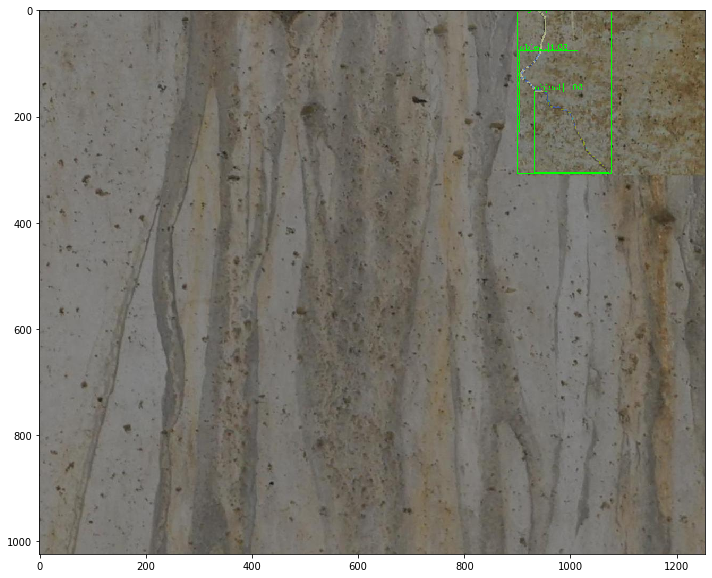